In [1]:
import os
os.chdir('../')

In [2]:
import scvelo as scv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scanpy as sc
import sklearn
from io import StringIO
from Bio import Phylo
import re

from ete3 import Tree
from matplotlib.colors import ListedColormap

import phylovelo as pv

In [3]:
ldata = scv.read("../datas/embryo/embryo3/embryo3out.loom", cache=True)
ldata.var_names_make_unique

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


<bound method AnnData.var_names_make_unique of AnnData object with n_obs × n_vars = 21658 × 32285
    obs: 'Clusters', '_X', '_Y'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'>

In [4]:
ldata.obs_names = [i[11:-1] for i in ldata.obs_names]

In [5]:
from ete3 import Tree
from io import StringIO

with open('/home/wangkun/datas/embryo/trees/embryo3_all.newick', 'r') as f:
    tree_nwk = f.readline()
t = Tree(tree_nwk)
f = StringIO(t.write())
tree = Phylo.read(f, 'newick')
f.close()

In [6]:
mut_num = pd.read_csv('/raid/wangkun/embryo3/Chan2019_embryo3_all_mutation_count.txt', sep='\t', index_col=0)
metadata = pd.read_csv('/raid/wangkun/embryo3/scRNA_metadata.csv', index_col=0)

In [7]:
terminals = [i.name for i in tree.get_terminals()]
# ldata.obs_names = [i[11:-1] for i in ldata.obs_names]
cell_names = list(set(ldata.obs_names).intersection(set(terminals)))

In [8]:
ldata = ldata[cell_names]

In [9]:
sd = pv.data_struct.scData(count=pd.DataFrame(ldata.X.A, index=ldata.obs_names, columns=ldata.var_names))
sd.phylo_tree = tree

In [10]:
sc.pp.filter_genes(ldata, min_counts=20)
sc.pp.normalize_total(ldata, inplace=True)
sc.pp.log1p(ldata)
sd.x_normed = pd.DataFrame(ldata.X.A, index=ldata.obs_names, columns=ldata.var_names)
sc.pp.highly_variable_genes(ldata, flavor="seurat", n_top_genes=2000)

Trying to set attribute `.var` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [11]:
sc.pp.pca(ldata)
sc.pp.neighbors(ldata)
sc.tl.tsne(ldata)

In [35]:
ldata.obs['clusters'] = metadata.loc[ldata.obs_names]['cluster']

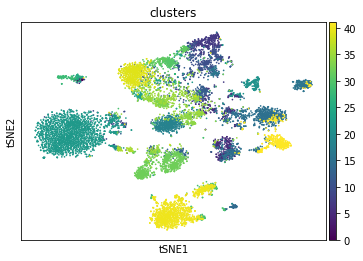

In [36]:
sc.pl.tsne(ldata, color=["clusters"])

In [37]:
sd.Xdr = pd.DataFrame(data=ldata.obsm['X_tsne'], index=ldata.obs_names)

In [38]:
sd.drop_duplicate_genes(target='x_normed')

In [10]:
tree_depths = tree.depths()
depths_map = dict()
for i in tree_depths:
    depths_map[i.name] = tree_depths[i]
depths = [depths_map[i] for i in sd.count.index]

# depths = [int(mut_num.loc[i]) for i in sd.count.index]

In [40]:
# np.random.shuffle(depths)

In [41]:
sd = pv.inference.velocity_inference(sd, depths, cutoff=0.97, target='x_normed')

  0%|          | 0/13906 [00:00<?, ?it/s]

In [17]:
sd = pv.embedding.velocity_embedding(sd, target='x_normed', n_neigh=300)

  0%|          | 0/10632 [00:00<?, ?it/s]

In [43]:
from scipy.stats import spearmanr
v_megs = pd.DataFrame(data=[sd.x_normed.columns, sd.velocity]).T
v_megs.columns = ['MEGs', 'v']
v_megs['p-value'] = v_megs['MEGs'].apply(lambda x: spearmanr(sd.x_normed[x], depths)[1])
v_megs[v_megs['v']!=0].to_csv('blood3_all_shuffle_megs.csv', index=False)

In [99]:
v_megs[v_megs['v']!=0].to_csv('embryo3_all.csv', index=False)

Text(0.04, 0.5, 'Total normalized UMI of MEGs')

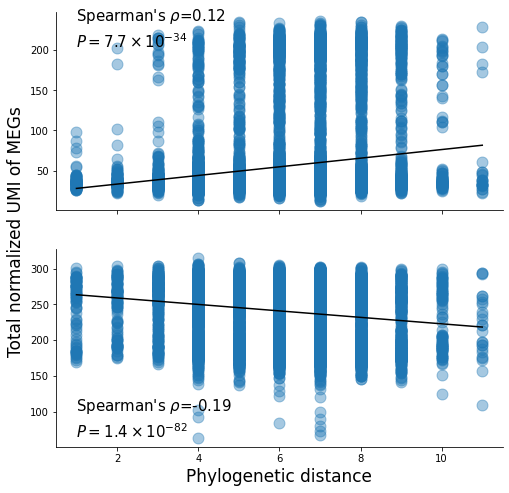

In [15]:

x = depths
y = sd.x_normed[genes1].sum(axis=1)

a, b = np.polyfit(x, y, deg=1)
y_est = a * np.linspace(min(x), max(x), 60) + b

fig, ax = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
ax[0].scatter(x, y, alpha=0.4, s=120)
ax[0].plot(np.linspace(min(x), max(x), 60), y_est, '-', c='k')
# ax[0].set_ylabel('Total normalized UMI of MEGs', fontsize=17)
# ax[0].set_xlabel('Phylogenetic distance', fontsize=17)
# ax.text(min(x)*1.1, max(y)*0.85, 'spearmanr={:.2g}\np_val={:.2g}'.format(*spearmanr(x, y)), fontsize=15)
rho, pval = spearmanr(x, y)

ax[0].text(min(x)*1, max(y), r"Spearman's $\rho$={:.2g}".format(rho), fontsize=15)
ax[0].text(min(x)*1, max(y)-(max(y)-min(y))*0.15, r'$P={}\times 10^{}$'.format(*r'{:.2g}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=15)

# ax.text(min(x)*1.1, min(y)*1.05, r"Spearman's $\rho$={:.2g}".format(rho), fontsize=15)
# ax.text(min(x)*1.1, min(y)*1, r'$P={}\times 10^{}$'.format(*r'{:.2g}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=15)

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)


x = depths
y = sd.x_normed[genes2].sum(axis=1)

a, b = np.polyfit(x, y, deg=1)
y_est = a * np.linspace(min(x), max(x), 60) + b


ax[1].scatter(x, y, alpha=0.4, s=120)
ax[1].plot(np.linspace(min(x), max(x), 60), y_est, '-', c='k')
# ax[1].set_ylabel('Total normalized UMI of MEGs', fontsize=17)
ax[1].set_xlabel('Phylogenetic distance', fontsize=17)
# ax.text(min(x)*1.1, max(y)*0.85, 'spearmanr={:.2g}\np_val={:.2g}'.format(*spearmanr(x, y)), fontsize=15)
rho, pval = spearmanr(x, y)

ax[1].text(min(x)*1, min(y)+(max(y)-min(y))*0.15, r"Spearman's $\rho$={:.2g}".format(rho), fontsize=15)
ax[1].text(min(x)*1, min(y)*1, r'$P={}\times 10^{}$'.format(*r'{:.2g}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=15)

ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

fig.text(0.04, 0.5, 'Total normalized UMI of MEGs', va='center', rotation='vertical',fontsize=17)